In [1]:
using PyPlot, SparseArrays
import Delaunator as D

In [17]:
"""
    edges, boundary_indices, emap = all_edges(t)

Handout from mesh_utilities
Find all unique edges in the triangulation `t` (ne x 2 array)
Second output is indices to the boundary edges.
Third output emap (nt x 3 array) is a mapping from local triangle edges
to the global edge list, i.e., emap[it,k] is the global edge number
for local edge k (1,2,3) in triangle it.
"""
function all_edges(t)
    etag = vcat(t[:,[1,2]], t[:,[2,3]], t[:,[3,1]])
    etag = hcat(sort(etag, dims=2), 1:3*size(t,1))
    etag = sortslices(etag, dims=1)
    dup = all(etag[2:end,1:2] - etag[1:end-1,1:2] .== 0, dims=2)[:]
    keep = .![false;dup]
    edges = etag[keep,1:2]
    emap = cumsum(keep)
    invpermute!(emap, etag[:,3])
    emap = reshape(emap,:,3)
    dup = [dup;false]
    dup = dup[keep]
    bndix = findall(.!dup)
    return edges, bndix, emap
end

"""
    t = delaunay(p)

Delaunay triangulation `t` of N x 2 node array `p`.
"""
delaunay(p) = collect(reinterpret(reshape, Int32, 
        D.triangulate(D.PointsFromMatrix(p')).triangles)')

"""
inside = inpolygon(p, pv)

Determine if each point in the N x 2 node array `p` is inside the polygon
described by the NE x 2 node array `pv`.
"""
function inpolygon(p, pv)
    if ndims(p) == 2 && size(p,2) == 2
        return [ inpolygon(p[ip,:], pv) for ip = 1:size(p,1) ]
    end
    cn = 0
    for i = 1:size(pv,1) - 1
        if pv[i,2] <= p[2] && pv[i+1,2] > p[2] ||
            pv[i,2] > p[2] && pv[i+1,2] <= p[2]
            vt = (p[2] - pv[i,2]) / (pv[i+1,2] - pv[i,2])
            if p[1] < pv[i,1] + vt * (pv[i+1,1] - pv[i,1])
                cn += 1
            end
        end
    end
    return cn % 2 == 1
end

"""
    e = boundary_nodes(t)

Find all boundary nodes in the triangulation `t`.
"""
function boundary_nodes(t)
    edges, boundary_indices, _ = all_edges(t)
    return unique(edges[boundary_indices,:][:])
end

"""
    tplot(p, t, u=nothing)

If `u` == nothing: Plot triangular mesh with nodes `p` and triangles `t`.
If `u` == solution vector: Plot filled contour color plot of solution `u`.
"""
function tplot(p, t, u=nothing)
    clf()
    axis("equal")
    if u == nothing
        tripcolor(p[:,1], p[:,2], Array(t .- 1), 0*t[:,1],
                  cmap="Set3", edgecolors="k", linewidth=1)
    else
        tricontourf(p[:,1], p[:,2], Array(t .- 1), u[:], 20)
    end
    draw()
end

tplot

In [18]:
# Helper functions

function area(p, triangle)
    points = [p[triangle[1],:] p[triangle[2],:] p[triangle[3],:]]
    x, y = points[1,:], points[2,:]
    return 1/2 * abs(x[1]*(y[2]-y[3]) + x[2]*(y[3]-y[1]) + x[3]*(y[1]-y[2]))
end

function findlargest(p, t)
    maxarea = 0
    maxindex = 0
    for i = 1:size(t, 1)
        if area(p, t[i, :]) > maxarea
            maxarea = area(p, t[i, :])
            maxindex = i
        end
    end
    return maxarea, maxindex
end

function circumcenter(A, B, C)
    # Formula obtained from https://en.wikipedia.org/wiki/Circumcircle
    B = B - A
    C = C - A
    D = 2 * (B[1]*C[2] - B[2]*C[1])
    Ux = 1 / D * (C[2] * (B[1]^2 + B[2]^2) - B[2] * (C[1]^2 + C[2]^2))
    Uy = 1 / D * (B[1] * (C[1]^2 + C[2]^2) - C[1] * (B[1]^2 + B[2]^2))
    U = [Ux + A[1], Uy + A[2]]
    return U
end

function deletetriangles(p, pv, t)
    badtriangles = []
    for i = 1:size(t, 1)
        triangle = t[i, :]
        midpoint = 1/3 * (p[triangle[1], :] + p[triangle[2],:] + p[triangle[3],:])
        if inpolygon(midpoint, pv) == false || area(p, triangle) < 10^-12
            badtriangles = push!(badtriangles, i)
        end
    end
    return t[begin:end .∉ [badtriangles],:]
end

function pmesh(pv, hmax, nref, savesolutions = false)
    N = size(pv, 1) - 1
    p = pv[1:end-1,:]
    # b) Adding nodes along each segment
    for i = 1:N
        segmentlength = sqrt((pv[i,1] - pv[i+1,1])^2 + (pv[i,2] - pv[i+1,2])^2)
        numnodes = trunc(Int32, ceil(segmentlength/hmax)) + 1
        if numnodes > 2
            extranodes = [LinRange(pv[i,1], pv[i+1,1], numnodes), LinRange(pv[i,2], pv[i+1,2], numnodes)]
            extranodes = [extranodes[1][begin+1:end-1] extranodes[2][begin+1:end-1]]
            p = vcat(p, extranodes)
        end
    end
    
    # c)
    t = delaunay(p)
    
    # d)
    t = deletetriangles(p, pv, t)
    if savesolutions
        allp = [copy(p)]
        allt = [copy(t)]
    end

    # e)-g)
    maxarea, maxindex = findlargest(p, t)
    while maxarea > hmax^2 /2
        indx = t[maxindex,:]
        circ = circumcenter(p[indx[1],:], p[indx[2],:], p[indx[3],:])
        p = vcat(p, reshape(circ,(1,2)))
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    
        t = delaunay(p)
        t = deletetriangles(p, pv, t)
        maxarea, maxindex = findlargest(p, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    end

    # h)
    for i = 1:nref
        edges, bndix, emap = all_edges(t)
        centerpoints = zeros(size(edges, 1), 2)
        for j = 1:size(edges, 1)
            centerpoints[j,:] = (p[edges[j,1],:] + p[edges[j,2],:])/2
        end
        p = vcat(p, centerpoints)
        t = delaunay(p)
        t = deletetriangles(p, pv, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))    
        end
    end
    
    e = boundary_nodes(t)
    if savesolutions
        return p, t, e, allp, allt
    else
        return p, t, e
    end
end

pmesh (generic function with 2 methods)

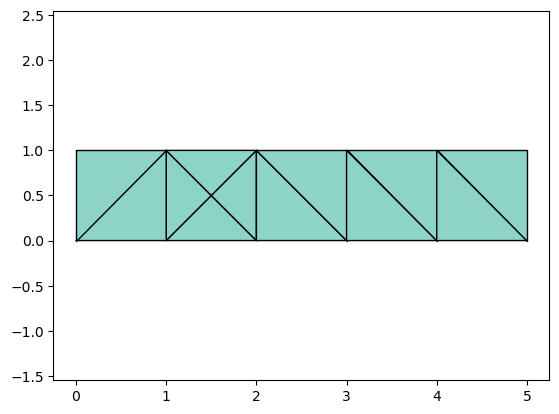

In [174]:
pv = [0 0; 5 0; 5 1; 0 1; 0 0]
p, t, e = pmesh(pv, 1, 0)
edges, bndix, emap = all_edges(t)

clf()
tplot(p, t)
gcf()

In [175]:
function waveguide_edges(p, t)
    edges, bndix, emap = all_edges(t)
    bndegdes = edges[bndix,:]

    inindx, outindx, wallindx = [], [], []
    for i = 1:size(bndegdes,1)
        if p[bndegdes[i,1],1] == 0 && p[bndegdes[i,2],1] == 0
            push!(inindx, i)
        elseif p[bndegdes[i,1],1] == 5 && p[bndegdes[i,2],1] == 5
            push!(outindx, i)
        else
            push!(wallindx, i)
        end
    end

    ein = bndegdes[inindx,:]
    eout = bndegdes[outindx,:]
    ewall = bndegdes[wallindx,:]

    return ein, eout, ewall
end

pv = [0 0; 5 0; 5 1; 0 1; 0 0]
p, t, e = pmesh(pv, 1, 0)

ein, eout, ewall = waveguide_edges(p,t)

display([p[ein[:,1],:] p[ein[:,2],:]])
display([p[eout[:,1],:] p[eout[:,2],:]])
display([p[ewall[:,1],:] p[ewall[:,2],:]])


1×4 Matrix{Float64}:
 0.0  0.0  0.0  1.0

1×4 Matrix{Float64}:
 5.0  0.0  5.0  1.0

10×4 Matrix{Float64}:
 0.0  0.0  1.0  0.0
 5.0  0.0  4.0  0.0
 5.0  1.0  4.0  1.0
 0.0  1.0  1.0  1.0
 1.0  0.0  2.0  0.0
 2.0  0.0  3.0  0.0
 3.0  0.0  4.0  0.0
 4.0  1.0  3.0  1.0
 3.0  1.0  2.0  1.0
 2.0  1.0  1.0  1.0